In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn import model_selection
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import minmax_scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Import data

In [2]:
# import train data
train_update = pd.read_csv('data/finaldf_train.csv')

In [3]:
#import test data
test_update = pd.read_csv('data/finaldf_test.csv')

In [4]:
# Derive target variable
train_update['profitable'] = train_update.apply(lambda x: 1 if x['revenue_adj'] - x['budget_adj'] > 0 else 0, axis=1)
test_update['profitable'] = test_update.apply(lambda x: 1 if x['revenue_adj'] - x['budget_adj'] > 0 else 0, axis=1)


# Drop unnecessary column
train_update.drop(['Unnamed: 0','id','revenue_adj','title','series_ind'],axis = 1, inplace = True)
test_update.drop(['Unnamed: 0','id','revenue_adj','title','series_ind'],axis = 1, inplace = True)


# Transform float feature into int64 (sunce those features are ont-hot encoding)
float_columns = train_update.select_dtypes(include=['float']).columns
train_update[float_columns] = train_update[float_columns].astype('int64')

float_columns = test_update.select_dtypes(include=['float']).columns
test_update[float_columns] = test_update[float_columns].astype('int64')

In [5]:
# standardscaler for runtime and total cast with skewed distribution
rscaler = StandardScaler()
rscaler.fit(train_update[['runtime']])
train_update['runtime'] = rscaler.transform(train_update[['runtime']])
test_update['runtime'] = rscaler.transform(test_update[['runtime']])

In [6]:
rscaler = StandardScaler()
rscaler.fit(train_update[['total_cast']])
train_update['total_cast'] = rscaler.transform(train_update[['total_cast']])
test_update['total_cast'] = rscaler.transform(test_update[['total_cast']])

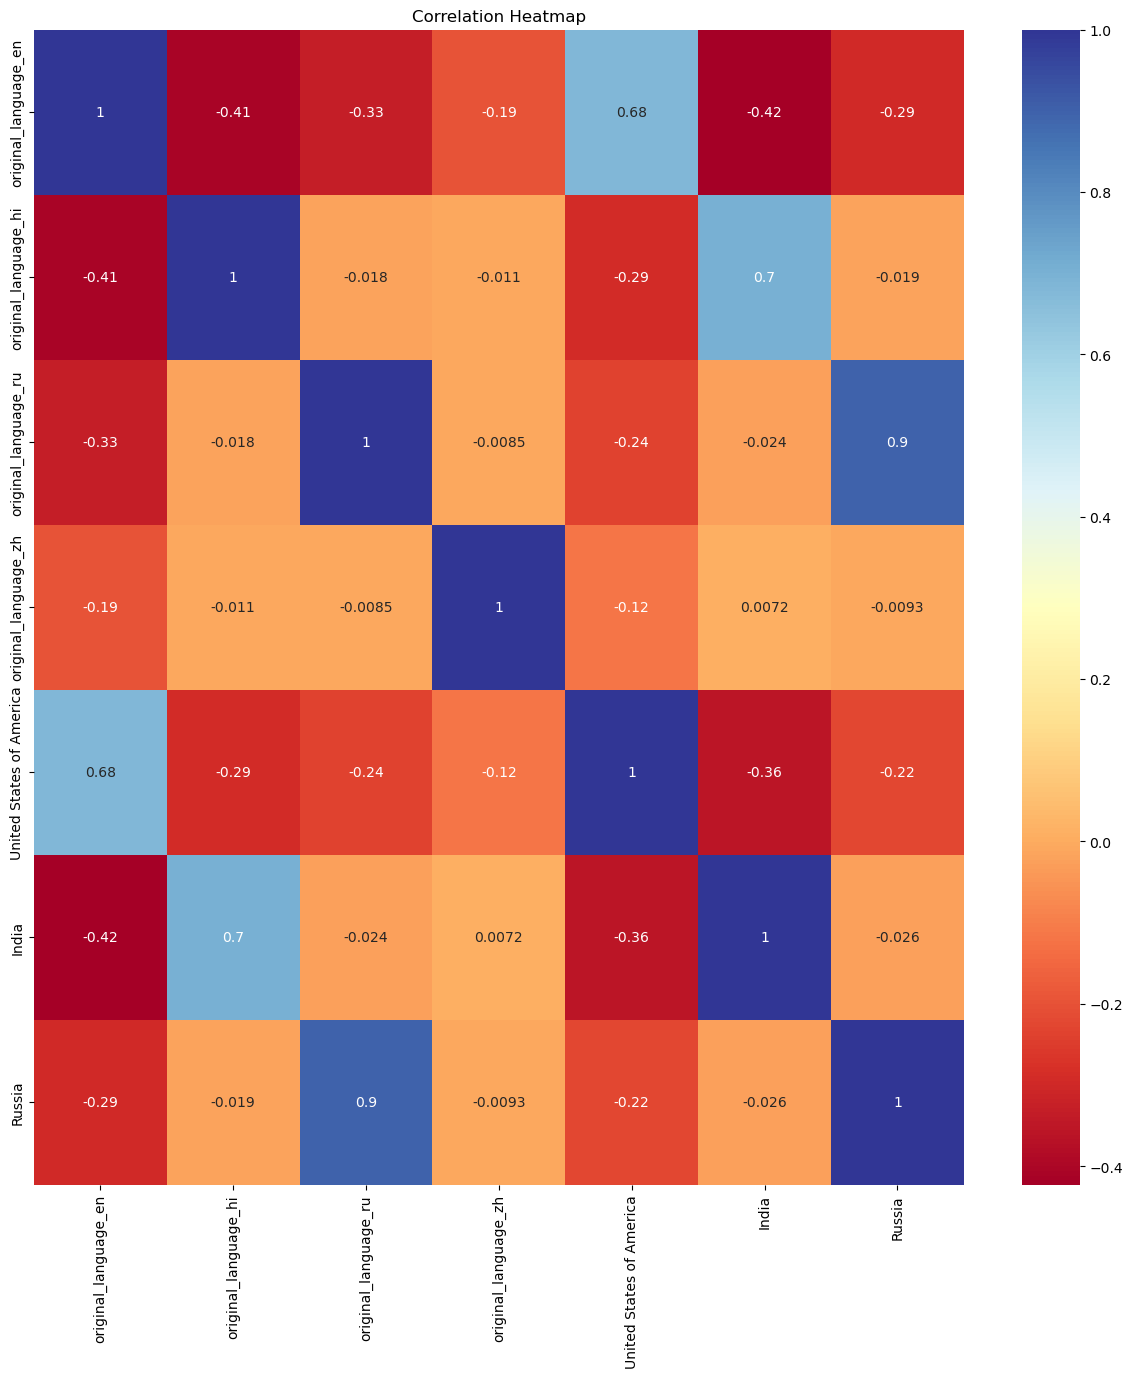

In [7]:
# check correlation of language and country
columns_of_interest = ['original_language_en', 
                       'original_language_hi',  
                       'original_language_ru', 
                       'original_language_zh', 'United States of America',
                        'India',  'Russia']

# Create a subset dataframe with the selected columns
subset_df = train_update[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Create a heatmap plot of the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')
plt.title('Correlation Heatmap')
plt.show()

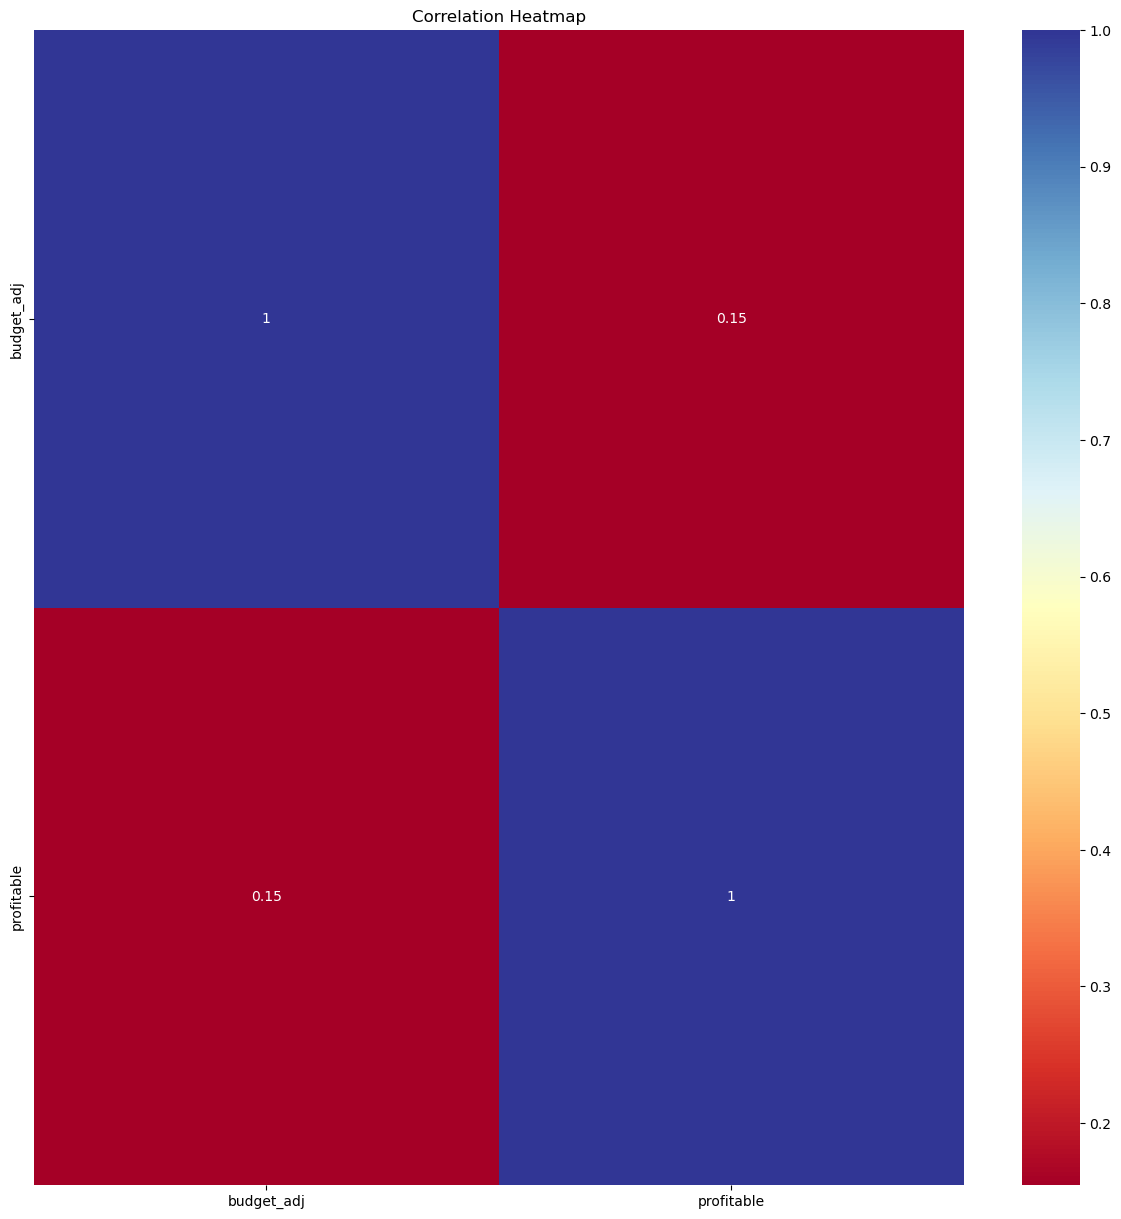

In [8]:
# check correlation of language and country
columns_of_interest = ['budget_adj', 'profitable']

# Create a subset dataframe with the selected columns
subset_df = train_update[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Create a heatmap plot of the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')
plt.title('Correlation Heatmap')
plt.show()

# Model without constraint

In [9]:
# transform budget_adj by log10
train_update['budget_log'] = np.log10(train_update['budget_adj'])
test_update['budget_log'] = np.log10(test_update['budget_adj'])


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.57      0.31      0.40       484
           1       0.72      0.88      0.79       962

    accuracy                           0.69      1446
   macro avg       0.65      0.60      0.60      1446
weighted avg       0.67      0.69      0.66      1446

Train Set:
Accuracy: 0.7152552375331956
Precision: 0.7401855817273376
Recall: 0.8974469926438771

Test Set:
Accuracy: 0.6922544951590595
Precision: 0.7181434599156118
Recall: 0.8846153846153846


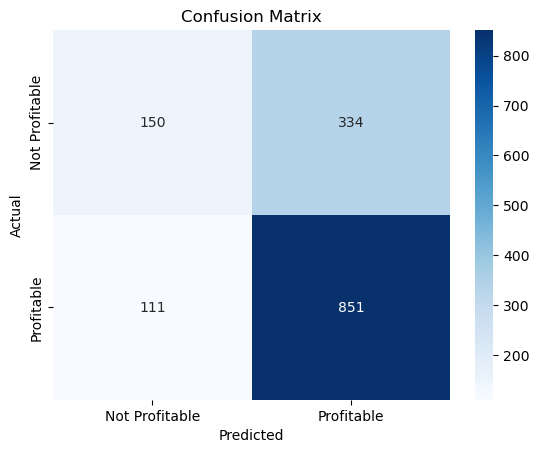

In [10]:
x_train = train_update.drop(['profitable', 'budget_adj'], axis=1)
y_train = train_update['profitable']

x_test = test_update.drop(['profitable', 'budget_adj'], axis=1)
y_test = test_update['profitable']

# use default solver lbfgs
estimator = linear_model.LogisticRegression(max_iter = 300,random_state=1234)
estimator.fit(x_train, y_train)

y_pred_train = estimator.predict(x_train)
train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
train_precision = metrics.precision_score(y_train, y_pred_train)
train_recall = metrics.recall_score(y_train, y_pred_train)

y_pred_test = estimator.predict(x_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
test_precision = metrics.precision_score(y_test, y_pred_test)
test_recall = metrics.recall_score(y_test, y_pred_test)

print("\nClassification Report (Test Set):")
print(metrics.classification_report(y_test, y_pred_test))

print("Train Set:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)

print("\nTest Set:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)

# Plot Confusion Matrix
labels = ['Not Profitable', 'Profitable']
cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title('Confusion Matrix')
plt.show()

# Build model without country feature (correlated with language)

In [11]:
x_train_lan= train_update.drop(['profitable', 'United States of America', 'United Kingdom', 'France',
       'Germany', 'Canada', 'India', 'Australia', 'Italy', 'Russia', 'Japan',
       'Other Country','budget_adj'],axis = 1)
y_train_lan = train_update.loc[:,'profitable']

x_test_lan = test_update.drop(['profitable', 'United States of America', 'United Kingdom', 'France',
       'Germany', 'Canada', 'India', 'Australia', 'Italy', 'Russia', 'Japan',
       'Other Country','budget_adj'],axis = 1)
y_test_lan = test_update.loc[:,'profitable']

estimator = linear_model.LogisticRegression(random_state=1234,max_iter = 300)
estimator.fit(x_train_lan, y_train_lan)

y_pred_train = estimator.predict(x_train_lan)
train_accuracy = metrics.accuracy_score(y_train_lan, y_pred_train)


y_pred_test = estimator.predict(x_test_lan)
test_accuracy = metrics.accuracy_score(y_test_lan, y_pred_test)


print("Train Set:")
print("Accuracy:", train_accuracy)


print("\nTest Set:")
print("Accuracy:", test_accuracy)


print("\nClassification Report (Test Set):")
print(metrics.classification_report(y_test_lan, y_pred_test))

Train Set:
Accuracy: 0.7111242254352317

Test Set:
Accuracy: 0.6984785615491009

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.59      0.31      0.41       484
           1       0.72      0.89      0.80       962

    accuracy                           0.70      1446
   macro avg       0.66      0.60      0.60      1446
weighted avg       0.68      0.70      0.67      1446



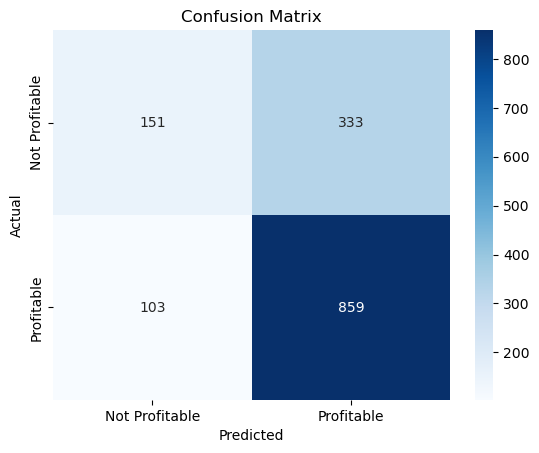

In [12]:
# Plot Confusion Matrix
labels = ['Not Profitable', 'Profitable']
cm = confusion_matrix(y_test_lan, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title('Confusion Matrix')
plt.show()

# Pick top features by RFE

In [13]:
model = linear_model.LogisticRegression(random_state=1234,max_iter=300)


rfe_model = RFE(model, n_features_to_select=10)
rfe_model.fit(x_train, y_train)


selected_indices = rfe_model.support_

# Get the selected feature names
selected_features = x_train.columns[selected_indices]

# Print the selected feature names
print(selected_features)

Index(['original_language_hi', 'original_language_ja', 'original_language_ta',
       'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'New Line Cinema', 'Walt Disney Pictures', 'Other Prod'],
      dtype='object')


Train Set:
Accuracy: 0.6886987311891414

Test Set:
Accuracy: 0.6728907330567082

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.64      0.05      0.10       484
           1       0.67      0.99      0.80       962

    accuracy                           0.67      1446
   macro avg       0.66      0.52      0.45      1446
weighted avg       0.66      0.67      0.56      1446



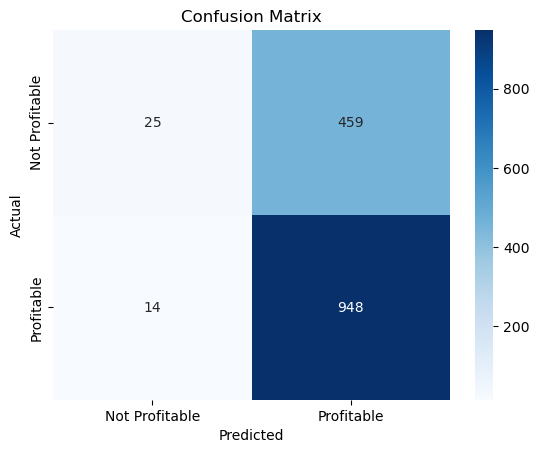

In [14]:
# Build a logistic regression model using the RFE features
x_train_rfe = x_train.iloc[:, selected_indices]
x_test_rfe = x_test.iloc[:, selected_indices]

estimator = linear_model.LogisticRegression(random_state=1234, max_iter=300)
estimator.fit(x_train_rfe, y_train_lan)

y_pred_train = estimator.predict(x_train_rfe)
train_accuracy = metrics.accuracy_score(y_train, y_pred_train)

y_pred_test = estimator.predict(x_test_rfe)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test)

print("Train Set:")
print("Accuracy:", train_accuracy)

print("\nTest Set:")
print("Accuracy:", test_accuracy)

print("\nClassification Report (Test Set):")
print(metrics.classification_report(y_test, y_pred_test))

# Calculate and plot the confusion matrix
confusion_mat = metrics.confusion_matrix(y_test, y_pred_test)

labels = ['Not Profitable', 'Profitable']
cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title('Confusion Matrix')
plt.show()

In [15]:
coefficients = estimator.coef_[0]

# Get the feature names from the x_train dataset
feature_names = x_test_rfe.columns

# Create a dataframe to store the feature names and coefficients
feature_coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the dataframe by absolute coefficient values in descending order
feature_coeff_df['Absolute Coefficient'] = feature_coeff_df['Coefficient'].abs()  # Compute absolute values
feature_coeff_df = feature_coeff_df.sort_values(by='Absolute Coefficient', ascending=False)

# Print the top 10 features with their coefficient values
top_10_features = feature_coeff_df[['Feature', 'Coefficient']]
top_10_features

,Feature,Coefficient
8,Walt Disney Pictures,1.643919
2,original_language_ta,1.223304
6,Columbia Pictures,1.211252
0,original_language_hi,1.208165
5,Twentieth Century Fox Film Corporation,0.969080
7,New Line Cinema,0.896615
3,Universal Pictures,0.873870
9,Other Prod,0.850741
4,Paramount Pictures,0.828441
1,original_language_ja,0.766270


# Grid search for L1, L2

In [16]:
param_grid = {
    'solver': ['saga', 'liblinear'],
    'penalty': ['l1'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [1000, 5000, 10000, 15000, 20000]
}

# Create the logistic regression model
estimator_l1 = LogisticRegression(penalty='l1', random_state=1234)

# Perform grid search using cross-validation
grid_search_l1 = GridSearchCV(estimator_l1, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_l1.fit(x_train_lan, y_train_lan)

# Get the best parameters and best score
best_params_l1 = grid_search_l1.best_params_
best_score_l1 = grid_search_l1.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params_l1)
print("Best Score:", best_score_l1)

Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.6996113340566354


In [17]:
# grid search for l2
param_grid = {
    'solver': ['lbfgs', 'saga', 'liblinear'],
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [1000, 5000, 10000, 15000, 20000]
}

estimator_l2 = LogisticRegression(penalty='l2', random_state=1234)


grid_search_l2 = GridSearchCV(estimator_l2, param_grid, cv=5, scoring='accuracy')


grid_search_l2.fit(x_train_lan, y_train_lan)


best_params_l2 = grid_search_l2.best_params_
best_score_l2 = grid_search_l2.best_score_


print("Best Parameters:", best_params_l2)
print("Best Score:", best_score_l2)


Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.6987255068561196


## Build L1 model

Train Set:
Accuracy: 0.7111242254352317

Test Set:
Accuracy: 0.6977869986168741

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.60      0.30      0.40       484
           1       0.72      0.90      0.80       962

    accuracy                           0.70      1446
   macro avg       0.66      0.60      0.60      1446
weighted avg       0.68      0.70      0.66      1446



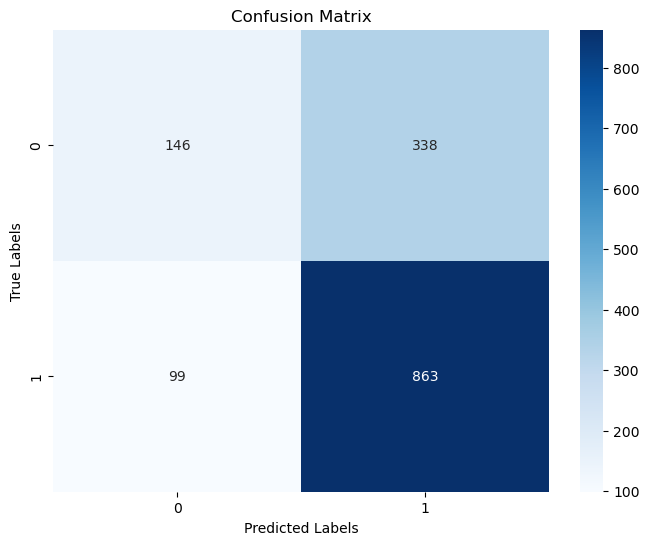

In [18]:
# Create the logistic regression model with the best parameters
logistic_model = linear_model.LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=500, random_state=1234)

# Fit the model to the training data
logistic_model.fit(x_train_lan, y_train_lan)

# Predict on the training set
y_pred_train = logistic_model.predict(x_train_lan)

# Calculate the training accuracy
train_accuracy = metrics.accuracy_score(y_train_lan, y_pred_train)

# Predict on the test set
y_pred_test = logistic_model.predict(x_test_lan)

# Calculate the test accuracy
test_accuracy = metrics.accuracy_score(y_test_lan, y_pred_test)

# Print the accuracies
print("Train Set:")
print("Accuracy:", train_accuracy)

print("\nTest Set:")
print("Accuracy:", test_accuracy)

# Calculate and print the classification report for the test set
print("\nClassification Report (Test Set):")
print(metrics.classification_report(y_test_lan, y_pred_test))

# Calculate and plot the confusion matrix for the test set
confusion_mat = metrics.confusion_matrix(y_test_lan, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [19]:
# Get the coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
feature_coefficients = pd.DataFrame({'Feature': x_train_lan.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients in descending order
feature_coefficients = feature_coefficients.reindex(feature_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Select the top 10 features
top_features = feature_coefficients.head(10)

top_features


,Feature,Coefficient
36,Walt Disney Pictures,1.536999
34,Columbia Pictures,1.109803
22,original_language_hi,0.940941
33,Twentieth Century Fox Film Corporation,0.899155
21,original_language_fr,-0.857077
27,original_language_ta,0.849921
32,Paramount Pictures,0.801238
31,Universal Pictures,0.696076
40,Other Prod,0.664422
35,New Line Cinema,0.663956


# Build L2 model

Train Set:
Accuracy: 0.7111242254352317

Test Set:
Accuracy: 0.6984785615491009

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.59      0.31      0.41       484
           1       0.72      0.89      0.80       962

    accuracy                           0.70      1446
   macro avg       0.66      0.60      0.60      1446
weighted avg       0.68      0.70      0.67      1446



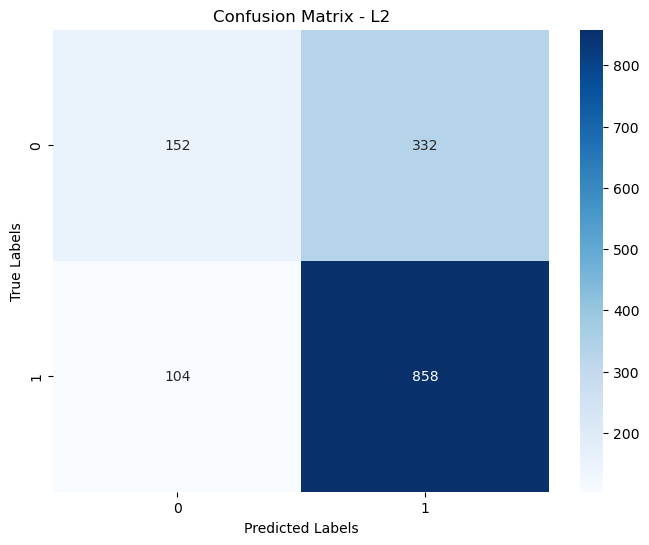

In [20]:
# Create the logistic regression model with the best parameters

logistic_model = linear_model.LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=10000, random_state=1234)

# Fit the model to the training data
logistic_model.fit(x_train_lan, y_train_lan)

# Predict on the training set
y_pred_train = logistic_model.predict(x_train_lan)

# Calculate the training accuracy
train_accuracy = metrics.accuracy_score(y_train_lan, y_pred_train)

# Predict on the test set
y_pred_test = logistic_model.predict(x_test_lan)

# Calculate the test accuracy
test_accuracy = metrics.accuracy_score(y_test_lan, y_pred_test)

# Print the accuracies
print("Train Set:")
print("Accuracy:", train_accuracy)

print("\nTest Set:")
print("Accuracy:", test_accuracy)

# Calculate and print the classification report for the test set
print("\nClassification Report (Test Set):")
print(metrics.classification_report(y_test_lan, y_pred_test))

# Calculate and plot the confusion matrix for the test set
confusion_mat = metrics.confusion_matrix(y_test_lan, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - L2')
plt.show()


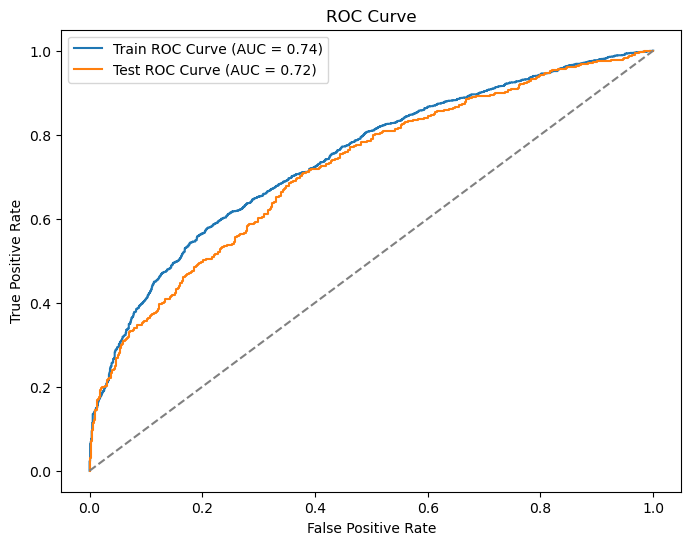

In [21]:
# Predict probabilities for the training set
y_pred_prob_train = logistic_model.predict_proba(x_train_lan)[:, 1]

# Predict probabilities for the test set
y_pred_prob_test = logistic_model.predict_proba(x_test_lan)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds for the training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train_lan, y_pred_prob_train)

# Calculate the false positive rate, true positive rate, and thresholds for the test set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test_lan, y_pred_prob_test)

# Calculate the AUC (Area Under the Curve) for the training set
roc_auc_train = metrics.roc_auc_score(y_train_lan, y_pred_prob_train)

# Calculate the AUC (Area Under the Curve) for the test set
roc_auc_test = metrics.roc_auc_score(y_test_lan, y_pred_prob_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], ls='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


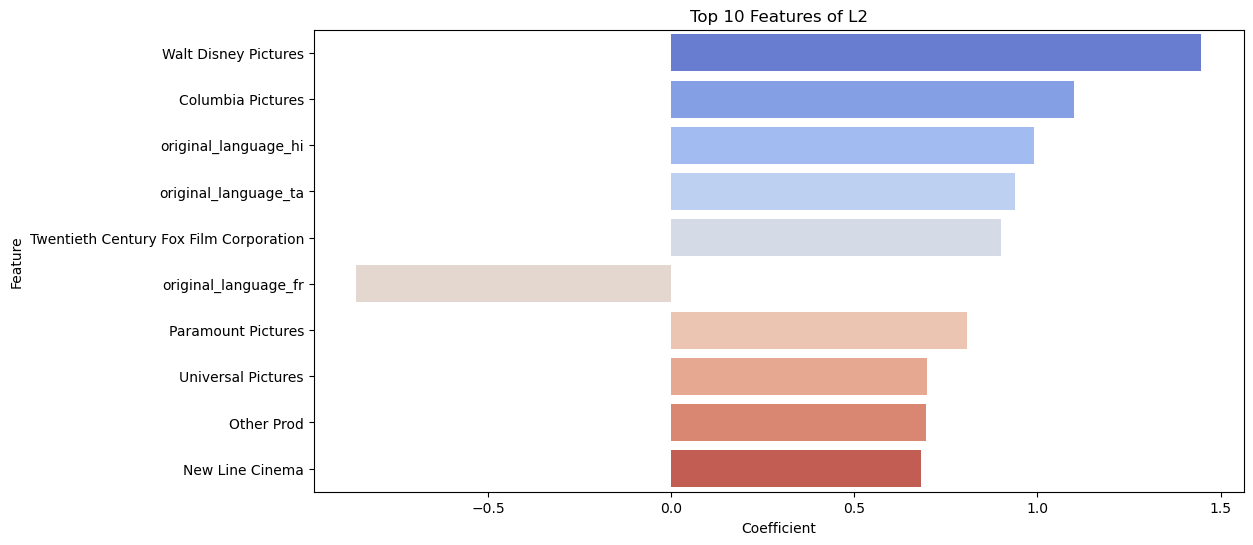

In [22]:
# Get the coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
feature_coefficients = pd.DataFrame({'Feature': x_train_lan.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients in descending order
feature_coefficients = feature_coefficients.reindex(feature_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Select the top 10 features
top_features = feature_coefficients.head(10)


# Plot the top feature bar chart with the specified palette
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Features of L2')
plt.show()



In [23]:
# Get the coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
feature_coefficients = pd.DataFrame({'Feature': x_train_lan.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients in descending order
feature_coefficients = feature_coefficients.reindex(feature_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Select the top 10 features
top_features = feature_coefficients.head(10)
top_features

,Feature,Coefficient
36,Walt Disney Pictures,1.447625
34,Columbia Pictures,1.098804
22,original_language_hi,0.989519
27,original_language_ta,0.939244
33,Twentieth Century Fox Film Corporation,0.899806
21,original_language_fr,-0.860396
32,Paramount Pictures,0.808850
31,Universal Pictures,0.699223
40,Other Prod,0.696300
35,New Line Cinema,0.682015


In [24]:
# Exclude budget
selected_columns = ['runtime', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Thriller', 'War', 'Western',
       'original_language_en', 'original_language_es', 'original_language_fr',
       'original_language_hi', 'original_language_it', 'original_language_ja',
       'original_language_ko', 'original_language_ru', 'original_language_ta',
       'original_language_zh', 'Warner Bros.', 'Universal Pictures',
       'Paramount Pictures', 'Twentieth Century Fox Film Corporation',
       'Columbia Pictures', 'New Line Cinema', 'Walt Disney Pictures',
       'Touchstone Pictures', 'Relativity Media', 'Metro-Goldwyn-Mayer (MGM)',
       'Other Prod', 'quarter_1', 'quarter_2', 'quarter_3', 'series_num',
       'total_popular_cast', 'top_director', 'total_cast', 'Topic_Topic 1',
       'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5',
       'Topic_Topic 6', 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9','budget_log']
x_train_lan_update2 = train_update[selected_columns]
x_test_lan_update2 = test_update[selected_columns]

Train Set:
Accuracy: 0.7102390085570965

Test Set:
Accuracy: 0.6957123098201936

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.59      0.31      0.41       484
           1       0.72      0.89      0.80       962

    accuracy                           0.70      1446
   macro avg       0.65      0.60      0.60      1446
weighted avg       0.67      0.70      0.66      1446



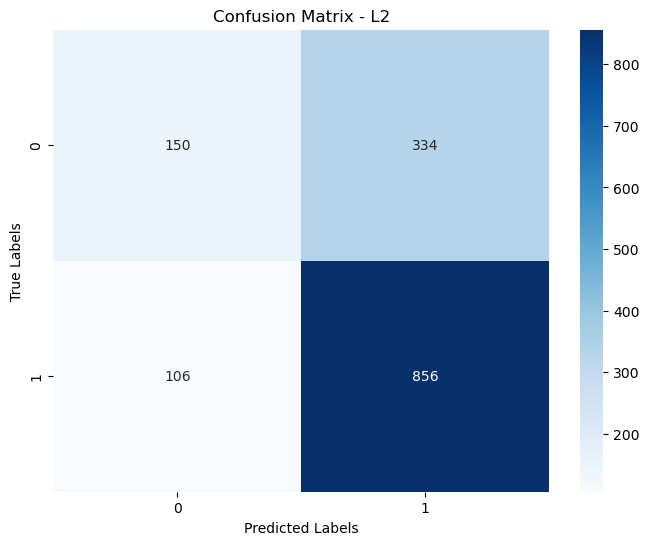

In [25]:
# Create the logistic regression model with the best parameters

logistic_model = linear_model.LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=10000, random_state=1234)

# Fit the model to the training data
logistic_model.fit(x_train_lan_update2, y_train_lan)

# Predict on the training set
y_pred_train = logistic_model.predict(x_train_lan_update2)

# Calculate the training accuracy
train_accuracy = metrics.accuracy_score(y_train_lan, y_pred_train)

# Predict on the test set
y_pred_test = logistic_model.predict(x_test_lan_update2)

# Calculate the test accuracy
test_accuracy = metrics.accuracy_score(y_test_lan, y_pred_test)

# Print the accuracies
print("Train Set:")
print("Accuracy:", train_accuracy)

print("\nTest Set:")
print("Accuracy:", test_accuracy)

# Calculate and print the classification report for the test set
print("\nClassification Report (Test Set):")
print(metrics.classification_report(y_test_lan, y_pred_test))

# Calculate and plot the confusion matrix for the test set
confusion_mat = metrics.confusion_matrix(y_test_lan, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - L2')
plt.show()


# SMOTE for imbalanced data

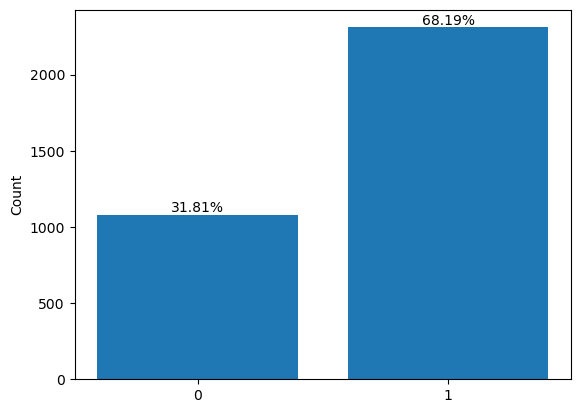

In [26]:
# Calculate the percentage of each category
total_count = len(y_train_lan)
class_0_count = y_train_lan.value_counts()[0]
class_1_count = y_train_lan.value_counts()[1]
class_0_percentage = class_0_count / total_count * 100
class_1_percentage = class_1_count / total_count * 100

# Create the countplot
plt.bar(['0', '1'], [class_0_count, class_1_count])

# Add percentage annotations
plt.text(0, class_0_count, f'{class_0_percentage:.2f}%', ha='center', va='bottom')
plt.text(1, class_1_count, f'{class_1_percentage:.2f}%', ha='center', va='bottom')

# Set the y-axis label
plt.ylabel('Count')

# Show the plot
plt.show()


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.49      0.59      0.54       484
           1       0.77      0.69      0.73       962

    accuracy                           0.66      1446
   macro avg       0.63      0.64      0.63      1446
weighted avg       0.68      0.66      0.67      1446



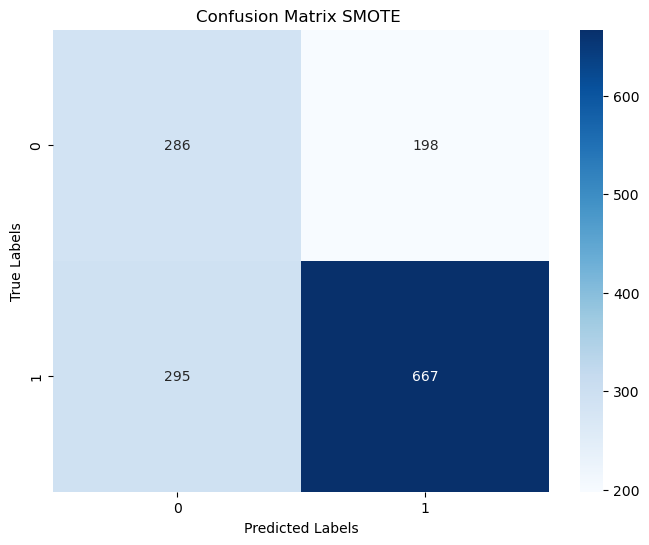

Train Set:
Accuracy: 0.6680436706993214

Test Set:
Accuracy: 0.6590594744121715


,Feature,Coefficient
35,Walt Disney Pictures,2.038266
33,Columbia Pictures,1.810023
32,Twentieth Century Fox Film Corporation,1.646116
22,original_language_hi,1.507294
27,original_language_ta,1.503829
48,Topic_Topic 2,1.477093
31,Paramount Pictures,1.423611
34,New Line Cinema,1.301135
30,Universal Pictures,1.260548
6,Documentary,1.228737


In [27]:
from imblearn.over_sampling import SMOTE

# Use budget with log10

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=1234)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_lan_update2, y_train_lan)

# Create and fit the logistic regression model
logreg = LogisticRegression(random_state=1234, max_iter=300)
logreg.fit(x_train_resampled, y_train_resampled)

# Predict on the training set
y_pred_train = logreg.predict(x_train_lan_update2)

# Calculate the training accuracy
train_accuracy = metrics.accuracy_score(y_train_lan, y_pred_train)

# Predict on the test set
y_pred_test = logreg.predict(x_test_lan_update2)

# Calculate the test accuracy
test_accuracy = metrics.accuracy_score(y_test_lan, y_pred_test)

# Calculate and print the classification report for the test set
classification_report_test = metrics.classification_report(y_test_lan, y_pred_test)
print("Classification Report (Test Set):")
print(classification_report_test)

# Calculate and plot the confusion matrix for the test set
confusion_mat = metrics.confusion_matrix(y_test_lan, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix SMOTE ')
plt.show()

# Print the accuracies
print("Train Set:")
print("Accuracy:", train_accuracy)

print("\nTest Set:")
print("Accuracy:", test_accuracy)

# Get the coefficients of the logistic regression model
coefficients = logreg.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
feature_coefficients = pd.DataFrame({'Feature': x_train_lan_update2.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients in descending order
feature_coefficients = feature_coefficients.reindex(feature_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Select the top 10 features
top_features = feature_coefficients.head(10)
top_features



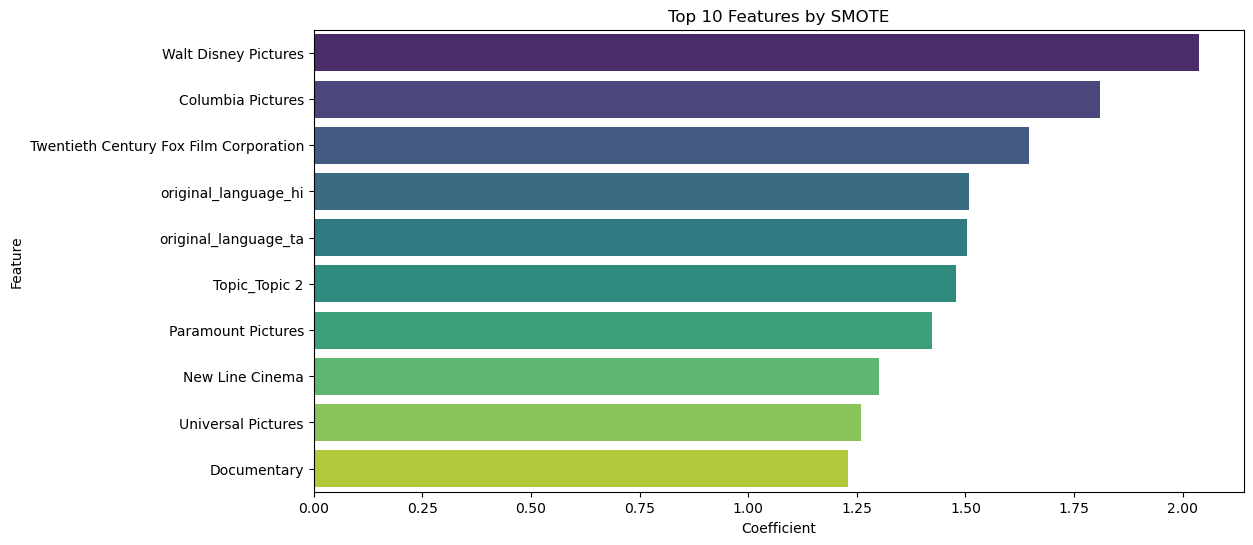

In [28]:
# Get the coefficients of the logistic regression model
coefficients = logreg.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
feature_coefficients = pd.DataFrame({'Feature': x_train_lan_update2.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients in descending order
feature_coefficients = feature_coefficients.reindex(feature_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Select the top 10 features
top_features = feature_coefficients.head(10)

# Plot the top feature bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='viridis')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Features by SMOTE')
plt.show()


# Class weight method

In [29]:
# Count the occurrences of each class
class_counts = np.bincount(y_train)

# Calculate the inverse class frequency
n_samples = len(y_train)
n_classes = len(class_counts)
class_weights = n_samples / (n_classes * class_counts)

# Print the inverse class frequency weights
print("Inverse Class Frequency Weights:", class_weights)


Inverse Class Frequency Weights: [1.57189239 0.73323237]


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.49      0.59      0.54       484
           1       0.77      0.69      0.73       962

    accuracy                           0.66      1446
   macro avg       0.63      0.64      0.63      1446
weighted avg       0.68      0.66      0.67      1446



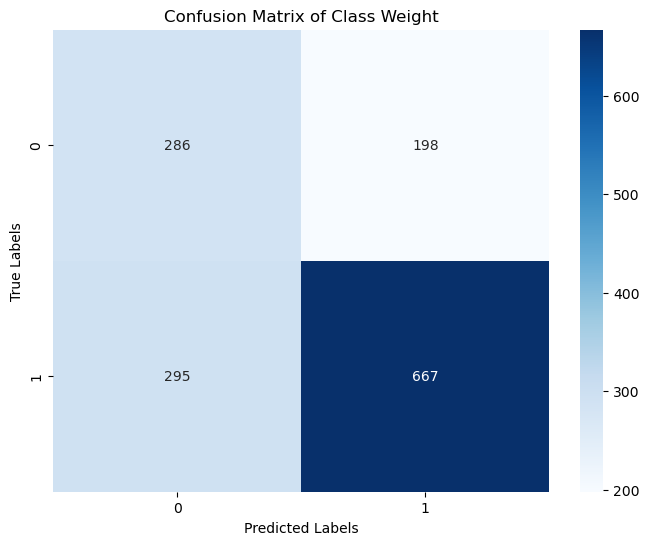

Train Set:
Accuracy: 0.6680436706993214

Test Set:
Accuracy: 0.6590594744121715


In [30]:
# Predict on the training set
y_pred_train = logreg.predict(x_train_lan_update2)

# Calculate the training accuracy
train_accuracy = metrics.accuracy_score(y_train_lan, y_pred_train)

# Predict on the test set
y_pred_test = logreg.predict(x_test_lan_update2)

# Calculate the test accuracy
test_accuracy = metrics.accuracy_score(y_test_lan, y_pred_test)

# Calculate and print the classification report for the test set
classification_report_test = metrics.classification_report(y_test_lan, y_pred_test)
print("Classification Report (Test Set):")
print(classification_report_test)

# Calculate and plot the confusion matrix for the test set
confusion_mat = metrics.confusion_matrix(y_test_lan, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Class Weight')
plt.show()

# Print the accuracies
print("Train Set:")
print("Accuracy:", train_accuracy)

print("\nTest Set:")
print("Accuracy:", test_accuracy)
